In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [3]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json
utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [5]:
def read_data(path):
    df = pd.read_csv(path)

    df.train_size = df.train_size.astype(int)
    df.random_seed = df.random_seed.astype(int)
    df.multiplier = df.multiplier.astype(float)
    for i in range(5):
        df[f"ext_bpoints_in_{chr(i+ord('a'))}"] = df[f"ext_bpoints_in_{chr(i+ord('a'))}"].astype(int)

    # lisame mugavusväärtused
    df["points_in_equal_regions"] = (df["train_size"] / 5).astype(int)
    df["points_in_diff_region"] = (
        df["points_in_equal_regions"] * df["multiplier"]).astype(int)
    df["total_points"] = 4*df["points_in_equal_regions"] + df["points_in_diff_region"]

    # tuunime välja väga kauged väärtused:
    cols_to_process = [*[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)],
                    *['mse_treeningul', 'mse_grid_testil', 'mse_treening_andmete_teine_myra'],
                    ]

    df[cols_to_process] = df.loc[:, cols_to_process][np.abs(stats.zscore(df.loc[:, cols_to_process])) < 3]
    df.dropna(inplace=True)

    df.sort_values(by=["train_size", "region", "multiplier", "random_seed"], inplace=True, ignore_index=True)
    df = df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()

    df["combo_name"] = df["train_size"].astype(str) + "_" + df["region"] + "_" + df["multiplier"].astype(str)
    return df

paths = ["andmed/all_four/const_order.csv", "andmed/all_four/const_reverse.csv", "andmed/all_four/sin_order.csv", "andmed/all_four/sin_reverse.csv"]
df = read_data(paths[0])


<AxesSubplot: xlabel='abs_diff_in_a', ylabel='raw_mean3_in_a'>

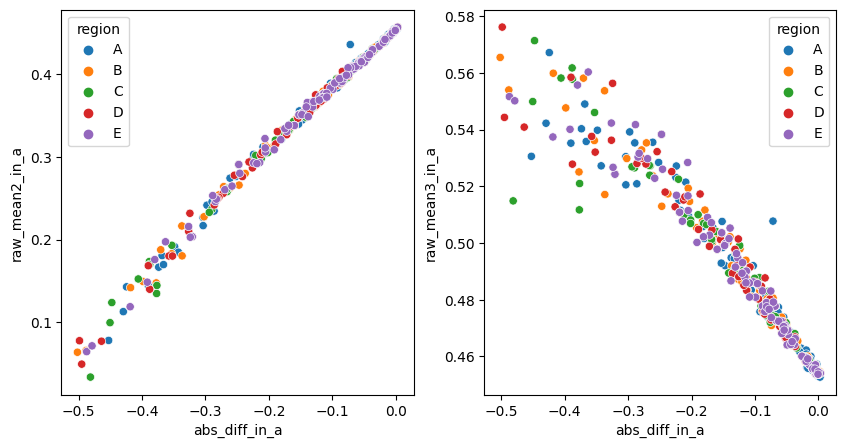

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), )
x = 10
sns.scatterplot(ax=ax[0], data=df, x="abs_diff_in_a",y="raw_mean2_in_a", hue="region",) #size="multiplier", sizes=(1*x, 5*x))
sns.scatterplot(ax=ax[1], data=df, x="abs_diff_in_a",y="raw_mean3_in_a", hue="region", )#size="multiplier", sizes=(1*x, 5*x))

## Regressioon

In [7]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [8]:
(df[df.points_in_diff_region == 0].points_in_diff_region +1 )** (-1)

0      1.0
95     1.0
190    1.0
285    1.0
380    1.0
Name: points_in_diff_region, dtype: float64

In [9]:
def create_regdf(df, y_col):
       reg_df = df.copy()

       reg_df = reg_df[reg_df.points_in_diff_region != 0] # TODO see on tegelikult halp

       reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])
       reg_df["diff_region_m1"] = reg_df["points_in_diff_region"] ** (-1)
       reg_df["diff_region_m2"] = reg_df["points_in_diff_region"] ** (-2)
       reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)

       # reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"]+1)
       # reg_df["diff_region_m1"] = (reg_df["points_in_diff_region"]+1) ** (-1)
       # reg_df["diff_region_m2"] = (reg_df["points_in_diff_region"]+1) ** (-2)
       # reg_df["diff_region_m3"] = (reg_df["points_in_diff_region"]+1) ** (-3)

       # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
       # 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

       #              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       #              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

       reg_df = reg_df[['region', 'multiplier', 'train_size', "log_diff_region", "points_in_diff_region", "points_in_equal_regions",
                            "diff_region_m1", "diff_region_m2", "diff_region_m3",
                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

       ohe = OneHotEncoder()
       ohetud_region = ohe.fit_transform(reg_df[["region"]], )
       reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[f"is_reg_{x}" for x in ohe.categories_[0]])], axis=1)
       reg_df.drop(columns=["region"], inplace=True)

       reg_df.dropna(inplace=True)
       reg_df.head()
       X = reg_df.drop(columns=[y_col])
       y = reg_df[y_col]

       scaler = MinMaxScaler()
       y_scaler = MinMaxScaler()
       X = scaler.fit_transform(X)
       y = y_scaler.fit_transform(y.values.reshape(-1, 1))

       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

       return reg_df, X_train, X_test, y_train, y_test, scaler, y_scaler

def transform_with_scalers(df, y_col, scaler, y_scaler):
       reg_df = df.copy()

       reg_df = reg_df[reg_df.points_in_diff_region != 0] # TODO see on tegelikult halp

       reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])
       reg_df["diff_region_m1"] = reg_df["points_in_diff_region"] ** (-1)
       reg_df["diff_region_m2"] = reg_df["points_in_diff_region"] ** (-2)
       reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)

       reg_df = reg_df[['region', 'multiplier', 'train_size', "log_diff_region", "points_in_diff_region", "points_in_equal_regions",
                            "diff_region_m1", "diff_region_m2", "diff_region_m3",
                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

       ohe = OneHotEncoder()
       ohetud_region = ohe.fit_transform(reg_df[["region"]])
       reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[f"is_reg_{x}" for x in ohe.categories_[0]])], axis=1)
       reg_df.drop(columns=["region"], inplace=True)

       reg_df.dropna(inplace=True)
       reg_df.head()
       X = reg_df.drop(columns=[y_col])
       y = reg_df[y_col]

       X = scaler.transform(X)
       y = y_scaler.transform(y.values.reshape(-1, 1))

       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

       return reg_df, X_train, X_test, y_train, y_test, scaler, y_scaler


reg_df, X_train, X_test, y_train, y_test, scaler, y_scaler = create_regdf(df, "rel_diff_in_a")

In [10]:
reg_model = Lasso(alpha=0.0001)
reg_model.fit(X_train, y_train)
mean_squared_error(y_test, reg_model.predict(X_test))

0.010235325752470199

In [11]:
from sklearn.linear_model import LassoCV

In [12]:
last_best = 0.0003
lasso_alphas = np.linspace(last_best -0.00001,last_best+0.00001,  100)

reg_model = LassoCV(cv=5, alphas=lasso_alphas,)
reg_model.fit(X_train, y_train.ravel())
print("MSE on: ", mean_squared_error(y_test, reg_model.predict(X_test)))
print("Score on: ", reg_model.score(X_test, y_test), "\n")

for n, c in zip(reg_df.columns, reg_model.coef_):
    print(f"{n:>25}: {c}")

MSE on:  0.010326883598432991
Score on:  0.8164433110723837 

               multiplier: -0.38248359197811577
               train_size: -0.016063396577492586
          log_diff_region: 1.1860200024219167
    points_in_diff_region: -0.0
  points_in_equal_regions: -0.28931013415898243
           diff_region_m1: -0.059563250157515034
           diff_region_m2: 0.0
           diff_region_m3: 0.0
             bpoints_in_a: 0.0
             bpoints_in_b: -0.2535019681674502
             bpoints_in_c: 0.23174451972920257
             bpoints_in_d: 0.043478321667102394
             bpoints_in_e: 0.04985909751549756
           mse_treeningul: -0.06463754755528726
            rel_diff_in_a: -0.0017239141739942385
                 is_reg_A: 0.003659909149042283
                 is_reg_B: -0.0
                 is_reg_C: -0.0033413776701995157
                 is_reg_D: 0.0006057757616794177


In [13]:
reg_model.alpha_

0.00028999999999999995

In [14]:
reverse_df = read_data(paths[1])
sin_df = read_data(paths[2])
sin_reverse_df = read_data(paths[3])

In [15]:
reg_df.shape

(465, 20)

## Katsetame erinevate featureidega

In [ ]:
reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])
reg_df["equal_regions_m1"] = reg_df["points_in_equal_regions"] ** (-1)
reg_df["equal_regions_m2"] = reg_df["points_in_equal_regions"] ** (-2)
reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)

In [ ]:
reg_df["diff_region_m5"] = reg_df["points_in_diff_region"] ** (-5)
reg_df["diff_region_m55"] = reg_df["points_in_diff_region"] ** (-5.5)

reg_df["equal_regions_m5"] = reg_df["points_in_equal_regions"] ** (-5)
reg_df["equal_regions_m55"] = reg_df["points_in_equal_regions"] ** (-5.5)

In [217]:
reg_df = df.copy()
y_col = "rel_diff_in_a"

# TODO see on tegelikult halp
reg_df = reg_df[reg_df.points_in_diff_region > 20]

reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])
reg_df["diff_region_m1"] = reg_df["points_in_diff_region"] ** (-1)
reg_df["diff_region_m2"] = reg_df["points_in_diff_region"] ** (-2)
reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)

reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])
reg_df["equal_regions_m1"] = reg_df["points_in_equal_regions"] ** (-1)
reg_df["equal_regions_m2"] = reg_df["points_in_equal_regions"] ** (-2)
reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)

# hunnikute viisi katsetusi
reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

reg_df["diff_region_m5"] = reg_df["points_in_diff_region"] ** (-5)

reg_df["equal_regions_m5"] = reg_df["points_in_equal_regions"] ** (-5)

reg_df["diff_region_m6"] = reg_df["points_in_diff_region"] ** (-6)

# 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
# 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

#              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
#              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

reg_df = reg_df[['region', 'multiplier',
                #  "log_diff_region", 
                 "diff_region_m1", "diff_region_m2", "diff_region_m3", "diff_region_m4",'diff_region_m5',"diff_region_m6",
                #  "log_equal_regions", 
                 "equal_regions_m1", "equal_regions_m2", "equal_regions_m3","equal_regions_m4", "equal_regions_m5",

                'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                 "mse_treeningul",
                 y_col]]

ohe = OneHotEncoder()
ohetud_region = ohe.fit_transform(reg_df[["region"]], )
reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
                   f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
reg_df.drop(columns=["region"], inplace=True)

reg_df.dropna(inplace=True)
reg_df.head()
X = reg_df.drop(columns=[y_col])
y = reg_df[y_col]

uuritavad_col = X.columns


scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = scaler.fit_transform(X, )
y = y_scaler.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
#pd.DataFrame(X_train, columns=['multiplier', 'log_diff_region', 'diff_region_m1', 'diff_region_m2',
                            #    'diff_region_m3', 'log_equal_regions', 'equal_regions_m1',
                            #    'equal_regions_m2', 'equal_regions_m3', 'bpoints_in_a', 'bpoints_in_b',
                            #    'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e', 'mse_treeningul',
                            #    'is_region_A', 'is_region_B', 'is_region_C', 'is_region_D',
                            #    'is_region_E']).head()
# return reg_df, X_train, X_test, y_train, y_test, scaler, y_scaler


In [218]:
letter = 'a'
# reg_df, X_train, X_test, y_train, y_test, _, _ = transform_with_scalers(new_df, 'rel_diff_in_'+letter, scaler, y_scaler)

#reg_df, X_train, X_test, y_train, y_test, scaler, y_scaler = create_regdf(df, "rel_diff_in_"+letter)

reg_model = Lasso(alpha=0.001)
reg_model.fit(X_train, y_train.ravel())
print("MSE on: ", mean_squared_error(y_test, reg_model.predict(X_test)))
print("Score on: ", reg_model.score(X_test, y_test), "\n")

for n, c in zip(uuritavad_col, reg_model.coef_):
    if c != 0:
        print(f"{n:>25}: {c}")
print("---------------")

MSE on:  0.009300973208469666
Score on:  0.8009515016060613 

           diff_region_m1: -0.16262523503889734
         equal_regions_m1: -0.3150410794384747
         equal_regions_m5: 0.022867715768007984
             bpoints_in_c: 0.09797011435856724
             bpoints_in_d: 0.04799451085877137
             bpoints_in_e: -0.008730712482563092
              is_region_A: -0.024589746237271594
              is_region_B: 0.010754512966330794
              is_region_C: 0.0008163002825568318
              is_region_D: -0.09505587381370476
---------------


In [358]:
mega_df = pd.concat([read_data(paths[0]),  read_data(paths[2]), ],ignore_index=True)
# mega_df.rel_diff_in_a = mega_df.rel_diff_in_a /mega_df.mse_treeningul

In [367]:
reg_df = mega_df.copy()
y_col = "rel_diff_in_c"

# TODO see on tegelikult halp
reg_df = reg_df[reg_df.points_in_diff_region > 0]

reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])
reg_df["diff_region_m1"] = reg_df["points_in_diff_region"] ** (-1)
reg_df["diff_region_m2"] = reg_df["points_in_diff_region"] ** (-2)
reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)

reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])
reg_df["equal_regions_m1"] = reg_df["points_in_equal_regions"] ** (-1)
reg_df["equal_regions_m2"] = reg_df["points_in_equal_regions"] ** (-2)
reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)

# hunnikute viisi katsetusi
reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

reg_df["diff_region_m5"] = reg_df["points_in_diff_region"] ** (-5)

reg_df["equal_regions_m5"] = reg_df["points_in_equal_regions"] ** (-5)

reg_df["diff_region_m6"] = reg_df["points_in_diff_region"] ** (-6)

# 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
# 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

#              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
#              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

reg_df = reg_df[['region', 'multiplier',
                 "log_diff_region", 
                 "diff_region_m1", "diff_region_m2", "diff_region_m3", "diff_region_m4",'diff_region_m5',"diff_region_m6",
                 "log_equal_regions", 
                 "equal_regions_m1", "equal_regions_m2", "equal_regions_m3","equal_regions_m4", "equal_regions_m5",

                'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                 "mse_treeningul",
                 y_col]]

ohe = OneHotEncoder()
ohetud_region = ohe.fit_transform(reg_df[["region"]], )
reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
                   f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
reg_df.drop(columns=["region"], inplace=True)

reg_df.dropna(inplace=True)
reg_df.reset_index(inplace=True, drop=True)

X = reg_df.drop(columns=[y_col])
y = reg_df[y_col]

uuritavad_col = X.columns


scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()
X = scaler.fit_transform(X,)
X = pd.DataFrame(X, columns=uuritavad_col)
# # y = y_scaler.fit_transform(y.values.reshape(-1, 1))


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, shuffle=True)
#pd.DataFrame(X_train, columns=['multiplier', 'log_diff_region', 'diff_region_m1', 'diff_region_m2',
                            #    'diff_region_m3', 'log_equal_regions', 'equal_regions_m1',
                            #    'equal_regions_m2', 'equal_regions_m3', 'bpoints_in_a', 'bpoints_in_b',
                            #    'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e', 'mse_treeningul',
                            #    'is_region_A', 'is_region_B', 'is_region_C', 'is_region_D',
                            #    'is_region_E']).head()
# return reg_df, X_train, X_test, y_train, y_test, scaler, y_scaler

In [368]:
print(X.columns)

Index(['multiplier', 'log_diff_region', 'diff_region_m1', 'diff_region_m2',
       'diff_region_m3', 'diff_region_m4', 'diff_region_m5', 'diff_region_m6',
       'log_equal_regions', 'equal_regions_m1', 'equal_regions_m2',
       'equal_regions_m3', 'equal_regions_m4', 'equal_regions_m5',
       'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d',
       'bpoints_in_e', 'mse_treeningul', 'is_region_A', 'is_region_B',
       'is_region_C', 'is_region_D', 'is_region_E'],
      dtype='object')


In [369]:
import operator
import statsmodels.api as sm

def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    print(f'Dropping {max_p_value} with p-value {results.pvalues[max_p_value]}')
    df.drop(columns = max_p_value, inplace = True)
    return df

insignificant_feature = True
while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:            
                X = remove_most_insignificant(X, results)
print(results.summary())

Dropping equal_regions_m2 with p-value 0.9894349644973398
Dropping log_equal_regions with p-value 0.9387961884279229
Dropping diff_region_m1 with p-value 0.8099981279890549
Dropping diff_region_m5 with p-value 0.8775575166187788
Dropping diff_region_m6 with p-value 0.9316996192135574
Dropping log_diff_region with p-value 0.4657316102104939
Dropping bpoints_in_e with p-value 0.38642170772472395
Dropping multiplier with p-value 0.2712706216561214
Dropping bpoints_in_b with p-value 0.1582275450748612
Dropping equal_regions_m4 with p-value 0.21491751667471873
Dropping equal_regions_m3 with p-value 0.4862918124068253
Dropping bpoints_in_c with p-value 0.07024011908884903
                            OLS Regression Results                            
Dep. Variable:          rel_diff_in_c   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     340.9
Date:    

In [381]:
cols = ['region', 'multiplier',
      "log_diff_region",
      "diff_region_m1", "diff_region_m2", "diff_region_m3", "diff_region_m4", 'diff_region_m5', "diff_region_m6",
      "log_equal_regions",
      "equal_regions_m1", "equal_regions_m2", "equal_regions_m3", "equal_regions_m4", "equal_regions_m5",

      'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
      "mse_treeningul", ]
dicty = {col: 1 for col in cols}
dicty

{'region': 1,
 'multiplier': 1,
 'log_diff_region': 1,
 'diff_region_m1': 1,
 'diff_region_m2': 1,
 'diff_region_m3': 1,
 'diff_region_m4': 1,
 'diff_region_m5': 1,
 'diff_region_m6': 1,
 'log_equal_regions': 1,
 'equal_regions_m1': 1,
 'equal_regions_m2': 1,
 'equal_regions_m3': 1,
 'equal_regions_m4': 1,
 'equal_regions_m5': 1,
 'bpoints_in_a': 1,
 'bpoints_in_b': 1,
 'bpoints_in_c': 1,
 'bpoints_in_d': 1,
 'bpoints_in_e': 1,
 'mse_treeningul': 1}

In [397]:
from tqdm import tqdm

In [408]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(suur_df, y_col):
    reg_df = suur_df.copy()
    # y_col = "rel_diff_in_a"

    # TODO see on tegelikult halp
    reg_df = reg_df[reg_df.points_in_diff_region > 0]

    reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])
    reg_df["diff_region_m1"] = reg_df["points_in_diff_region"] ** (-1)
    reg_df["diff_region_m2"] = reg_df["points_in_diff_region"] ** (-2)
    reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)

    reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])
    reg_df["equal_regions_m1"] = reg_df["points_in_equal_regions"] ** (-1)
    reg_df["equal_regions_m2"] = reg_df["points_in_equal_regions"] ** (-2)
    reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)

    # hunnikute viisi katsetusi
    reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

    reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

    reg_df["diff_region_m5"] = reg_df["points_in_diff_region"] ** (-5)

    reg_df["equal_regions_m5"] = reg_df["points_in_equal_regions"] ** (-5)

    reg_df["diff_region_m6"] = reg_df["points_in_diff_region"] ** (-6)

    # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
    # 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

    #              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
    #              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

    reg_df = reg_df[['region', 'multiplier',
                    "log_diff_region",
                     "diff_region_m1", "diff_region_m2", "diff_region_m3", "diff_region_m4", 'diff_region_m5', "diff_region_m6",
                     "log_equal_regions",
                     "equal_regions_m1", "equal_regions_m2", "equal_regions_m3", "equal_regions_m4", "equal_regions_m5",

                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

    ohe = OneHotEncoder()
    ohetud_region = ohe.fit_transform(reg_df[["region"]], )
    reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
        f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
    reg_df.drop(columns=["region"], inplace=True)

    reg_df.dropna(inplace=True)
    reg_df.reset_index(inplace=True, drop=True)

    X = reg_df.drop(columns=[y_col])
    y = reg_df[y_col]

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    kasutusel_featured = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m1': 1, 'diff_region_m2': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'diff_region_m5': 1, 'diff_region_m6': 1, 'log_equal_regions': 1,
                          'equal_regions_m1': 1, 'equal_regions_m2': 1, 'equal_regions_m3': 1, 'equal_regions_m4': 1, 'equal_regions_m5': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_A': 1, 'is_region_B': 1, 'is_region_C': 1, 'is_region_D': 1, 'is_region_E': 1}

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        # if v:
        #     print(k)
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    print(results.summary())
    print()


kf = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m1': 1, 'diff_region_m2': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'diff_region_m5': 1, 'diff_region_m6': 1, 'log_equal_regions': 1,
      'equal_regions_m1': 1, 'equal_regions_m2': 1, 'equal_regions_m3': 1, 'equal_regions_m4': 1, 'equal_regions_m5': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1, 'is_region_A': 1, 'is_region_B': 1, 'is_region_C': 1, 'is_region_D': 1, 'is_region_E': 1}
print("predict_region", sep=";", end=";")

for k, v in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for reldif in ["rel_diff_in_a", "rel_diff_in_b", "rel_diff_in_c", "rel_diff_in_d", "rel_diff_in_e"]:
        print(reldif, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        mega_df = pd.concat([read_data(paths[p])
                            for p in kombo], ignore_index=True)
        kogu_asi(mega_df, reldif)
        # if reldif == "rel_diff_in_b":
        #     a = 5/0
        # print()
        break
    break 
    print()

    # mega_df = pd.concat([read_data(paths[0]),  read_data(paths[2]), ],ignore_index=True)


predict_region;region;multiplier;log_diff_region;diff_region_m1;diff_region_m2;diff_region_m3;diff_region_m4;diff_region_m5;diff_region_m6;log_equal_regions;equal_regions_m1;equal_regions_m2;equal_regions_m3;equal_regions_m4;equal_regions_m5;bpoints_in_a;bpoints_in_b;bpoints_in_c;bpoints_in_d;bpoints_in_e;mse_treeningul;is_region_A;is_region_B;is_region_C;is_region_D;is_region_E;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
rel_diff_in_a;1;1;0;1;0;0;1;1;1;0;1;0;1;1;1;1;1;1;0;1;1;0;0;1;1;0;0.9656280678183233;11.46171100949444;-5187.51660950748;-5099.097746893942;                                 OLS Regression Results                                
Dep. Variable:          rel_diff_in_a   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              3231.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                        0

## sama asi, aga diff = 0 on sees

In [412]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(suur_df, y_col):
    reg_df = suur_df.copy()
    # y_col = "rel_diff_in_a"

    # TODO see on tegelikult halp
    reg_df.points_in_diff_region = reg_df.points_in_diff_region+1

    reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])
    reg_df["diff_region_m1"] = reg_df["points_in_diff_region"] ** (-1)
    reg_df["diff_region_m2"] = reg_df["points_in_diff_region"] ** (-2)
    reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)

    reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])
    reg_df["equal_regions_m1"] = reg_df["points_in_equal_regions"] ** (-1)
    reg_df["equal_regions_m2"] = reg_df["points_in_equal_regions"] ** (-2)
    reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)

    # hunnikute viisi katsetusi
    reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

    reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

    reg_df["diff_region_m5"] = reg_df["points_in_diff_region"] ** (-5)

    reg_df["equal_regions_m5"] = reg_df["points_in_equal_regions"] ** (-5)

    reg_df["diff_region_m6"] = reg_df["points_in_diff_region"] ** (-6)

    # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
    # 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

    #              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
    #              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

    reg_df = reg_df[['region', 'multiplier',
                    "log_diff_region",
                     "diff_region_m1", "diff_region_m2", "diff_region_m3", "diff_region_m4", 'diff_region_m5', "diff_region_m6",
                     "log_equal_regions",
                     "equal_regions_m1", "equal_regions_m2", "equal_regions_m3", "equal_regions_m4", "equal_regions_m5",

                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

    ohe = OneHotEncoder()
    ohetud_region = ohe.fit_transform(reg_df[["region"]], )
    reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
        f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
    reg_df.drop(columns=["region"], inplace=True)

    reg_df.dropna(inplace=True)
    reg_df.reset_index(inplace=True, drop=True)

    X = reg_df.drop(columns=[y_col])
    y = reg_df[y_col]

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    kasutusel_featured = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m1': 1, 'diff_region_m2': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'diff_region_m5': 1, 'diff_region_m6': 1, 'log_equal_regions': 1,
                          'equal_regions_m1': 1, 'equal_regions_m2': 1, 'equal_regions_m3': 1, 'equal_regions_m4': 1, 'equal_regions_m5': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_A': 1, 'is_region_B': 1, 'is_region_C': 1, 'is_region_D': 1, 'is_region_E': 1}

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        # if v:
        #     print(k)
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    print()


kf = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m1': 1, 'diff_region_m2': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'diff_region_m5': 1, 'diff_region_m6': 1, 'log_equal_regions': 1,
      'equal_regions_m1': 1, 'equal_regions_m2': 1, 'equal_regions_m3': 1, 'equal_regions_m4': 1, 'equal_regions_m5': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1, 'is_region_A': 1, 'is_region_B': 1, 'is_region_C': 1, 'is_region_D': 1, 'is_region_E': 1}
print("predict_region", sep=";", end=";")

for k, v in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for reldif in ["rel_diff_in_a", "rel_diff_in_b", "rel_diff_in_c", "rel_diff_in_d", "rel_diff_in_e"]:
        print(reldif, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        mega_df = pd.concat([read_data(paths[p])
                            for p in kombo], ignore_index=True)
        kogu_asi(mega_df, reldif)
        # if reldif == "rel_diff_in_b":
        #     a = 5/0
        # print()

    print()

    # mega_df = pd.concat([read_data(paths[0]),  read_data(paths[2]), ],ignore_index=True)


predict_region;region;multiplier;log_diff_region;diff_region_m1;diff_region_m2;diff_region_m3;diff_region_m4;diff_region_m5;diff_region_m6;log_equal_regions;equal_regions_m1;equal_regions_m2;equal_regions_m3;equal_regions_m4;equal_regions_m5;bpoints_in_a;bpoints_in_b;bpoints_in_c;bpoints_in_d;bpoints_in_e;mse_treeningul;is_region_A;is_region_B;is_region_C;is_region_D;is_region_E;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
rel_diff_in_a;1;1;0;1;0;1;1;0;0;0;1;0;1;1;1;1;1;1;0;1;1;1;1;1;1;0;0.9644568446555986;11.539788539836673;-5144.787149468411;-5050.479620860557;
rel_diff_in_b;1;1;1;0;0;1;0;0;0;0;0;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.5097075247664893;1.5582646178570807;-2754.2929063964566;-2654.4378761057874;
rel_diff_in_c;1;1;0;0;0;0;0;0;0;0;1;1;1;1;0;1;1;1;1;1;0;1;1;1;1;1;0.36787078656808536;1.9428081708105072;-1610.1741946973202;-1526.9616694550957;
rel_diff_in_d;1;1;1;0;1;1;0;0;0;1;0;0;0;0;0;1;1;1;1;1;1;1;1;1;1;1;0.4112848564826376;2.570312468662743;-1293.096496415044;-1204.3364694900044;

## sama asi, aga ainult lemmikud astmed

In [413]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(suur_df, y_col):
    reg_df = suur_df.copy()
    # y_col = "rel_diff_in_a"

    # TODO see on tegelikult halp
    reg_df.points_in_diff_region = reg_df.points_in_diff_region+1

    reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])

    reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)
    reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

    reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])

    reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)
    reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

    # hunnikute viisi katsetusi


    # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
    # 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

    #              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
    #              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

    reg_df = reg_df[['region', 'multiplier',
                    "log_diff_region",
                     "diff_region_m3", "diff_region_m4", 
                     "log_equal_regions",
                     "equal_regions_m3", "equal_regions_m4",

                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

    ohe = OneHotEncoder()
    ohetud_region = ohe.fit_transform(reg_df[["region"]], )
    reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
        f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
    reg_df.drop(columns=["region"], inplace=True)

    reg_df.dropna(inplace=True)
    reg_df.reset_index(inplace=True, drop=True)

    X = reg_df.drop(columns=[y_col])
    y = reg_df[y_col]

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    kasutusel_featured = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'log_equal_regions': 1,
                          'equal_regions_m3': 1, 'equal_regions_m4': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_A': 1, 'is_region_B': 1, 'is_region_C': 1, 'is_region_D': 1, 'is_region_E': 1}

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        # if v:
        #     print(k)
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    print()


kf = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'log_equal_regions': 1,
                          'equal_regions_m3': 1, 'equal_regions_m4': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_A': 1, 'is_region_B': 1, 'is_region_C': 1, 'is_region_D': 1, 'is_region_E': 1}
print("predict_region", sep=";", end=";")

for k, v in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for reldif in ["rel_diff_in_a", "rel_diff_in_b", "rel_diff_in_c", "rel_diff_in_d", "rel_diff_in_e"]:
        print(reldif, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        mega_df = pd.concat([read_data(paths[p])
                            for p in kombo], ignore_index=True)
        kogu_asi(mega_df, reldif)
        # if reldif == "rel_diff_in_b":
        #     a = 5/0
        # print()

    print()

    # mega_df = pd.concat([read_data(paths[0]),  read_data(paths[2]), ],ignore_index=True)


predict_region;region;multiplier;log_diff_region;diff_region_m3;diff_region_m4;log_equal_regions;equal_regions_m3;equal_regions_m4;bpoints_in_a;bpoints_in_b;bpoints_in_c;bpoints_in_d;bpoints_in_e;mse_treeningul;is_region_A;is_region_B;is_region_C;is_region_D;is_region_E;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
rel_diff_in_a;1;1;1;1;1;1;1;1;0;1;1;1;1;1;1;1;1;1;1;0.8921731296238605;4.955131226469464;-4610.717580911489;-4516.410052303634;
rel_diff_in_b;1;1;1;1;0;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.5042762030443301;1.638013879657245;-2735.4050358225995;-2641.0975072147453;
rel_diff_in_c;1;1;0;0;0;1;1;1;1;1;1;1;1;0;1;1;1;1;1;0.3648324227633948;2.074974342835719;-1603.082798184872;-1525.4177746254625;
rel_diff_in_d;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;1;1;1;0.4111580635181039;2.5695200798048927;-1292.6881944044358;-1203.9281674793963;
rel_diff_in_e;1;1;1;0;0;1;1;0;1;1;1;1;1;1;1;1;1;1;1;0.47023144815631035;4.009728424735476;-1036.743772733978;-953.5312474917534;

Komboks oli: (0, 1)
rel_diff_in_a;1;0;1

In [393]:
paths[0]

'andmed/all_four/const_order.csv'

In [419]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(suur_df, y_col):
    reg_df = suur_df.copy()
    # y_col = "rel_diff_in_a"

    # TODO see on tegelikult halp
    reg_df.points_in_diff_region = reg_df.points_in_diff_region+1

    reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])

    reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)
    reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

    reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])

    reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)
    reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

    # hunnikute viisi katsetusi


    # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
    # 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

    #              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
    #              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

    reg_df = reg_df[['region', 'multiplier',
                    "log_diff_region",
                     "diff_region_m3", "diff_region_m4", 
                     "log_equal_regions",
                     "equal_regions_m3", "equal_regions_m4",

                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

    ohe = OneHotEncoder()
    ohetud_region = ohe.fit_transform(reg_df[["region"]], )
    reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
        f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
    reg_df.drop(columns=["region"], inplace=True)

    reg_df["is_region_aar"] = reg_df.is_region_A + reg_df.is_region_E
    reg_df.drop(columns=["is_region_A", "is_region_B", "is_region_C", "is_region_D", "is_region_E"], inplace=True)

    reg_df.dropna(inplace=True)
    reg_df.reset_index(inplace=True, drop=True)

    X = reg_df.drop(columns=[y_col])
    y = reg_df[y_col]

    uuritavad_col = X.columns
    # print(uuritavad_col)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    kasutusel_featured = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'log_equal_regions': 1,
                          'equal_regions_m3': 1, 'equal_regions_m4': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_aar':1}

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        # if v:
        #     print(k)
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    print()


kf = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'log_equal_regions': 1,
                          'equal_regions_m3': 1, 'equal_regions_m4': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_aar':1}
print("predict_region", sep=";", end=";")

for k, v in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for reldif in ["rel_diff_in_a", "rel_diff_in_b", "rel_diff_in_c", "rel_diff_in_d", "rel_diff_in_e"]:
        print(reldif, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        mega_df = pd.concat([read_data(paths[p])
                            for p in kombo], ignore_index=True)
        kogu_asi(mega_df, reldif)
        # if reldif == "rel_diff_in_b":
        #     a = 5/0

    print()

    # mega_df = pd.concat([read_data(paths[0]),  read_data(paths[2]), ],ignore_index=True)


predict_region;region;multiplier;log_diff_region;diff_region_m3;diff_region_m4;log_equal_regions;equal_regions_m3;equal_regions_m4;bpoints_in_a;bpoints_in_b;bpoints_in_c;bpoints_in_d;bpoints_in_e;mse_treeningul;is_region_aar;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
rel_diff_in_a;1;1;1;1;1;1;1;1;1;1;0;1;1;1;1;0.9431545659778512;14.757183981150982;-4262.447734472293;-4190.330212595698;
rel_diff_in_b;1;1;1;1;0;1;1;1;1;1;1;1;1;1;0;0.669449411820967;4.520357368803598;-2671.776028750368;-2605.206008556588;
rel_diff_in_c;1;1;0;0;0;1;1;1;1;1;1;1;1;1;0;0.4339318776381649;3.7444332172154184;-1536.5067734992713;-1481.0317566711217;
rel_diff_in_d;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;0.3894371802707479;3.0494228650653343;-1227.5249533218707;-1160.9549331280912;
rel_diff_in_e;1;1;1;0;0;1;1;0;1;0;1;1;1;1;1;0.45261852797847246;5.760026480555744;-863.5382215889617;-808.063204760812;

Komboks oli: (0, 1)
rel_diff_in_a;1;0;1;1;1;1;1;1;1;1;1;1;1;1;1;0.9478168069296653;6.324601640730085;-2343.133892278467;-2280.

In [421]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(suur_df, y_col):
    reg_df = suur_df.copy()
    # y_col = "rel_diff_in_a"

    # TODO see on tegelikult halp
    reg_df.points_in_diff_region = reg_df.points_in_diff_region+1

    reg_df["log_diff_region"] = np.log(reg_df["points_in_diff_region"])

    reg_df["diff_region_m3"] = reg_df["points_in_diff_region"] ** (-3)
    reg_df["diff_region_m4"] = reg_df["points_in_diff_region"] ** (-4)

    reg_df["log_equal_regions"] = np.log(reg_df["points_in_equal_regions"])

    reg_df["equal_regions_m3"] = reg_df["points_in_equal_regions"] ** (-3)
    reg_df["equal_regions_m4"] = reg_df["points_in_equal_regions"] ** (-4)

    # hunnikute viisi katsetusi


    # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
    # 'points_in_equal_regions', 'points_in_diff_region', 'total_points',

    #              'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
    #              'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d', 'rel_diff_in_e',

    reg_df = reg_df[['region', 'multiplier',
                    "log_diff_region",
                     "diff_region_m3", "diff_region_m4", 
                     "log_equal_regions",
                     "equal_regions_m3", "equal_regions_m4",

                     'bpoints_in_a', 'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
                     # 'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c','ext_bpoints_in_d', 'ext_bpoints_in_e',
                     "mse_treeningul",
                     y_col]]

    ohe = OneHotEncoder()
    ohetud_region = ohe.fit_transform(reg_df[["region"]], )
    reg_df = pd.concat([reg_df, pd.DataFrame(ohetud_region.toarray(), columns=[
        f"is_region_{x}" for x in ohe.categories_[0]])], axis=1)
    reg_df.drop(columns=["region"], inplace=True)

    reg_df["is_region_aar"] = reg_df.is_region_A + reg_df.is_region_E
    reg_df.drop(columns=["is_region_A", "is_region_B", "is_region_C", "is_region_D", "is_region_E"], inplace=True)

    reg_df.dropna(inplace=True)
    reg_df.reset_index(inplace=True, drop=True)

    X = reg_df.drop(columns=[y_col])
    y = reg_df[y_col]

    uuritavad_col = X.columns
    # print(uuritavad_col)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    kasutusel_featured = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'log_equal_regions': 1,
                          'equal_regions_m3': 1, 'equal_regions_m4': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_aar':1}

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        # if v:
        #     print(k)
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    print(results.summary())
    print()


kf = {'region': 1, 'multiplier': 1, 'log_diff_region': 1, 'diff_region_m3': 1, 'diff_region_m4': 1, 'log_equal_regions': 1,
                          'equal_regions_m3': 1, 'equal_regions_m4': 1, 'bpoints_in_a': 1, 'bpoints_in_b': 1, 'bpoints_in_c': 1, 'bpoints_in_d': 1, 'bpoints_in_e': 1, 'mse_treeningul': 1,
                          'is_region_aar':1}
print("predict_region", sep=";", end=";")

for k, v in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for reldif in ["rel_diff_in_c", "rel_diff_in_d", "rel_diff_in_e"]:
        print(reldif, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        mega_df = pd.concat([read_data(paths[p])
                            for p in kombo], ignore_index=True)
        kogu_asi(mega_df, reldif)
        if reldif == "rel_diff_in_c":
            a = 5/0

    print()

    # mega_df = pd.concat([read_data(paths[0]),  read_data(paths[2]), ],ignore_index=True)

# tunnuseks bpoitns_in_current_rel_dif
# tunnuseks naaber_bpoints_from_current_rel_dif
# my_region, 
# kas mina diff, naaber diff, kaugemal on diff
# vï siis minu kordaja, naabri kordaja, kaugema kordaja (multiplieri põhine)

# samad bpointside ja andmepunktide, my, neighbour, distant (6kokku, multiplier ei pane)




# 

predict_region;region;multiplier;log_diff_region;diff_region_m3;diff_region_m4;log_equal_regions;equal_regions_m3;equal_regions_m4;bpoints_in_a;bpoints_in_b;bpoints_in_c;bpoints_in_d;bpoints_in_e;mse_treeningul;is_region_aar;r2;mse;aic;bic;
Komboks oli: (0, 1)
rel_diff_in_c;1;1;0;1;1;1;1;1;1;1;1;1;0;1;0;0.6042875782580974;2.236218875120604;-1146.353762233518;-1092.9790939739473;                                 OLS Regression Results                                
Dep. Variable:          rel_diff_in_c   R-squared (uncentered):                   0.604
Model:                            OLS   Adj. R-squared (uncentered):              0.600
Method:                 Least Squares   F-statistic:                              129.8
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                   1.26e-179
Time:                        10:45:22   Log-Likelihood:                          584.18
No. Observations:                 946   AIC:                                     -1146.
Df 

ZeroDivisionError: division by zero

# With new features
- tunnuseks bpoitns_in_current_rel_dif
- tunnuseks naaber_bpoints_from_current_rel_dif
- my_region, 
- kas mina diff, naaber diff, kaugemal on diff
- vï siis minu kordaja, naabri kordaja, kaugema kordaja (multiplieri põhine)
- samad bpointside ja andmepunktide, my, neighbour, distant (6kokku, multiplier ei pane)



In [422]:
df_order = read_data(paths[0])

andmed/all_four/const_order.csv


In [423]:
df_order.columns

Index(['region', 'multiplier', 'train_size', 'random_seed', 'bpoints_in_a',
       'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
       'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c',
       'ext_bpoints_in_d', 'ext_bpoints_in_e', 'abs_diff_in_a',
       'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d',
       'rel_diff_in_e', 'raw_mean2_in_a', 'raw_mean2_in_b', 'raw_mean2_in_c',
       'raw_mean2_in_d', 'raw_mean2_in_e', 'raw_mean3_in_a', 'raw_mean3_in_b',
       'raw_mean3_in_c', 'raw_mean3_in_d', 'raw_mean3_in_e', 'mse_treeningul',
       'mse_grid_testil', 'mse_treening_andmete_teine_myra',
       'points_in_equal_regions', 'points_in_diff_region', 'total_points',
       'combo_name'],
      dtype='object')

In [471]:
ma_olen_reg = 'b'
naabrid = ['a','c']
naabrid_upper = ['A','C']
kaugemad = ['d','e']
kaugemad_upper = ['D','E']

y_col = "rel_diff_in_"+ma_olen_reg

df_new = pd.DataFrame()
df_new["my_bpoints"] = df_order["bpoints_in_"+ma_olen_reg]
df_new["neighbour_bpoints"] = (df_order["bpoints_in_"+naabrid[0]] + df_order["bpoints_in_"+naabrid[1]])/2
df_new["distant_bpoints"] = (df_order["bpoints_in_"+kaugemad[0]] + df_order["bpoints_in_"+kaugemad[1]])/2

df_new["my_rel_diff"] = df_order["rel_diff_in_"+ma_olen_reg]
df_new["neighbour_rel_diff"] = (df_order["rel_diff_in_"+naabrid[0]] + df_order["rel_diff_in_"+naabrid[1]])/2
df_new["distant_rel_diff"] = (df_order["rel_diff_in_"+kaugemad[0]] + df_order["rel_diff_in_"+kaugemad[1]])/2

# minus olevad punktid
df_new["my_points"] =  (df_order["train_size"]/5 * df_order["multiplier"] * (df_order["region"] == ma_olen_reg.upper())) + (df_order["train_size"]/5 * (df_order["region"] != ma_olen_reg.upper()))
df_new["my_points"] = df_new["my_points"].astype(int)

df_new["neighbour_points"] = (df_order["train_size"]/5 * df_order["multiplier"] * (df_order["region"] == naabrid_upper[0])) + (df_order["train_size"]/5 * (df_order["region"]!=naabrid_upper[0]))
df_new["neighbour_points"] += (df_order["train_size"]/5 * df_order["multiplier"] * (df_order["region"] == naabrid_upper[1])) + (df_order["train_size"]/5 * (df_order["region"]!=naabrid_upper[1]))
df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)

df_new["distant_points"] =  (df_order["train_size"]/5 * df_order["multiplier"] * (df_order["region"] == kaugemad_upper[0])) + (df_order["train_size"]/5 * (df_order["region"] != kaugemad_upper[0]))
df_new["distant_points"] += (df_order["train_size"]/5 * df_order["multiplier"] * (df_order["region"] == kaugemad_upper[1])) + (df_order["train_size"]/5 * (df_order["region"] != kaugemad_upper[1]))
df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)

# et ei oleks ühtegi nulli enam
df_new["my_points"] = (df_new["my_points"]+1).astype(float)
df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


df_new["my_points_m1"] = df_new["my_points"] ** (-1)
df_new["my_points_m2"] = df_new["my_points"] ** (-2)
df_new["my_points_m3"] = df_new["my_points"] ** (-3)
df_new["my_points_m4"] = df_new["my_points"] ** (-4)
df_new["my_points_m5"] = df_new["my_points"] ** (-5)
df_new["my_points_m6"] = df_new["my_points"] ** (-6)
df_new["my_points_log"] = np.log(df_new["my_points"])


df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
df_new["neighbour_points_m2"] = df_new["neighbour_points"] ** (-2)
df_new["neighbour_points_m3"] = df_new["neighbour_points"] ** (-3)
df_new["neighbour_points_m4"] = df_new["neighbour_points"] ** (-4)
df_new["neighbour_points_m5"] = df_new["neighbour_points"] ** (-5)
df_new["neighbour_points_m6"] = df_new["neighbour_points"] ** (-6)
df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])


df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
df_new["distant_points_m2"] = df_new["distant_points"] ** (-2)
df_new["distant_points_m3"] = df_new["distant_points"] ** (-3)
df_new["distant_points_m4"] = df_new["distant_points"] ** (-4)
df_new["distant_points_m5"] = df_new["distant_points"] ** (-5)
df_new["distant_points_m6"] = df_new["distant_points"] ** (-6)
df_new["distant_points_log"] = np.log(df_new["distant_points"])

df_new["mse_treeningul"] = df_order["mse_treeningul"]
df_new.dropna(inplace=True)
df_new.reset_index(inplace=True, drop=True)

X = df_new.drop(columns=['my_rel_diff'])
y = df_new['my_rel_diff']

uuritavad_col = X.columns

scaler = MinMaxScaler()
X = scaler.fit_transform(X,)
X = pd.DataFrame(X, columns=uuritavad_col)

# df_new["region"] = df_order["region"]
# # df_new["multiplier"] = df_order["multiplier"]
# # df_new["train_size"] = df_order["train_size"]
# # df_new["total_points"] = df_order["total_points"]

# df_new[df_new.region=="D"].head(30)

## Uus transform

In [514]:
def new_transform(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]


    y_col = "rel_diff_in_"+ma_olen_reg

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]


    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    if len(naabrid) == 2:
        df_new["neighbour_rel_diff"] = (df["rel_diff_in_"+naabrid[0]] + df["rel_diff_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_rel_diff"] = df["rel_diff_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_rel_diff"] = (df["rel_diff_in_"+kaugemad[0]] + df["rel_diff_in_"+kaugemad[1]])/2
    else:
        df_new["distant_rel_diff"] = df["rel_diff_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    # df_new["my_points_m2"] = df_new["my_points"] ** (-2)
    # df_new["my_points_m3"] = df_new["my_points"] ** (-3)
    # df_new["my_points_m4"] = df_new["my_points"] ** (-4)
    # df_new["my_points_m5"] = df_new["my_points"] ** (-5)
    # df_new["my_points_m6"] = df_new["my_points"] ** (-6)
    df_new["my_points_log"] = np.log(df_new["my_points"])


    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    # df_new["neighbour_points_m2"] = df_new["neighbour_points"] ** (-2)
    # df_new["neighbour_points_m3"] = df_new["neighbour_points"] ** (-3)
    # df_new["neighbour_points_m4"] = df_new["neighbour_points"] ** (-4)
    # df_new["neighbour_points_m5"] = df_new["neighbour_points"] ** (-5)
    # df_new["neighbour_points_m6"] = df_new["neighbour_points"] ** (-6)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    # df_new["distant_points_m2"] = df_new["distant_points"] ** (-2)
    # df_new["distant_points_m3"] = df_new["distant_points"] ** (-3)
    # df_new["distant_points_m4"] = df_new["distant_points"] ** (-4)
    # df_new["distant_points_m5"] = df_new["distant_points"] ** (-5)
    # df_new["distant_points_m6"] = df_new["distant_points"] ** (-6)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])

    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)


    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    return X, y
uus_x, uus_y = new_transform(df_order, 'b', ['a','c'], ['d'])

uus_x.head()

,my_bpoints,neighbour_bpoints,distant_bpoints,neighbour_rel_diff,distant_rel_diff,my_points,neighbour_points,distant_points,my_points_m1,my_points_log,neighbour_points_m1,neighbour_points_log,distant_points_m1,distant_points_log,mse_treeningul
0,0.786540,0.661417,0.173611,0.557183,0.094709,0.00125,0.000000,0.00125,0.332917,0.148896,1.000000,0.000000,0.332917,0.148896,0.434014
1,0.757432,0.000000,0.555556,0.211802,0.332805,0.00250,0.001001,0.00250,0.199500,0.218129,0.665999,0.065233,0.199500,0.218129,0.416949
2,0.850110,0.193049,0.383142,0.301206,0.674189,0.00375,0.002002,0.00375,0.142321,0.263731,0.498999,0.111517,0.142321,0.263731,0.614349
3,0.644384,0.288775,0.306848,0.387842,0.741406,0.00500,0.004004,0.00500,0.110556,0.297792,0.331999,0.176751,0.110556,0.297792,0.567813
4,0.414602,0.447069,0.270062,0.364492,0.742405,0.00625,0.005005,0.00625,0.090341,0.324989,0.284284,0.201551,0.090341,0.324989,0.602476


In [500]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

In [504]:
r, n, k = list(zip(regioon, naabrid, kaugemad))[3]

('d', ['c', 'e'], ['b'])

In [517]:
dfikene = read_data(paths[2])

r, n, k = list(zip(regioon, naabrid, kaugemad))[3]
uus_x, uus_y = new_transform(dfikene, r,n,k)

reg = Lasso(alpha=0.001)
reg.fit(uus_x,uus_y)
for name, coef in zip(uus_x.columns, reg.coef_):
    if coef != 0:
        print(name, coef)

neighbour_bpoints -0.07330579908216013
my_points_m1 -0.4058427117154751
my_points_log 0.15821129253661317
mse_treeningul 0.022116739808180012


In [498]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    print(f'Dropping {max_p_value} with p-value {results.pvalues[max_p_value]}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value

dfikene = read_data(paths[2])
uus_x, uus_y = new_transform(dfikene, 'e', ['d'], ['c'])


insignificant_feature = True
while insignificant_feature:
    model = sm.OLS(uus_y, uus_x)
    results = model.fit()
    significant = [p_value < 0.05 for p_value in results.pvalues]
    if all(significant):
        insignificant_feature = False
    else:
        if X.shape[1] == 1:  # if there's only one insignificant variable left
            print('No significant features found')
            results = None
            insignificant_feature = False
        else:
            X, removed = remove_most_insignificant(uus_x, results)
            # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
            # kasutusel_featured[removed] = 0

# for k, v in kasutusel_featured.items():
#     # if v:
#     #     print(k)
#     print(v, sep=";", end=";")

# print(results.rsquared, sep=";", end=";")
# print(results.mse_model, sep=";", end=";")
# print(results.aic, sep=";", end=";")
# print(results.bic, sep=";", end=";")
print(results.summary())
print()

Dropping neighbour_points_m6 with p-value 0.8246031733354561
Dropping neighbour_points with p-value 0.7524002810276856
Dropping my_bpoints with p-value 0.5854275864209085
Dropping distant_points with p-value 0.5739278825763454
Dropping distant_points_m1 with p-value 0.47983791905512274
Dropping distant_points_m2 with p-value 0.2724957128942023
Dropping neighbour_points_m5 with p-value 0.3088006574239501
Dropping neighbour_points_log with p-value 0.5254564240226569
Dropping my_points with p-value 0.14135798714347278
Dropping distant_points_m6 with p-value 0.16464296530660777
Dropping distant_points_m3 with p-value 0.41960360475069947
Dropping mse_treeningul with p-value 0.07749128169122074
Dropping my_points_m6 with p-value 0.14963808307269488
                                 OLS Regression Results                                
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.804
Model:                            OLS   Adj. R-squared (uncentered):   

In [522]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(suur_df, r,n,k):
    
    X, y = new_transform(suur_df, r,n,k)

    kasutusel_featured = {col: 1 for col in X.columns}


    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())


X, y = new_transform(df_order, 'b', ['a','c'], ['d'])
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for r, n, k in regioonide_combod:

        print(r, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)

        mega_df = pd.concat([read_data(paths[p])
                            for p in kombo], ignore_index=True)
        kogu_asi(mega_df, r,n,k)
        print()
    print()


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;neighbour_rel_diff;distant_rel_diff;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;neighbour_points_m1;neighbour_points_log;distant_points_m1;distant_points_log;mse_treeningul;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
a;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.9351288938578675;12.680728072728417;-4008.0498059134443;-3924.8372806712196;
b;1;1;1;1;1;1;1;1;1;0;0;1;1;1;1;0.8565059468794087;5.338549606290301;-4251.923793219239;-4179.806271342644;
c;1;0;1;1;1;1;1;1;1;1;0;1;1;1;1;0.8185777526913772;5.433518105926135;-3687.9410109791643;-3615.8234891025695;
d;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.7690304839723774;4.817411917634053;-3064.6179274911556;-2981.405402248931;
e;1;1;1;1;1;1;0;1;0;1;1;1;1;1;1;0.6890910120743006;6.745674561055721;-1930.0025119607658;-1857.8849900841712;

Komboks oli: (0, 1)
a;1;1;1;1;1;1;1;1;1;1;1;0;1;1;1;0.9348668872502481;5.792604335910362;-2131.4316192282113;-2063.500223261485;
b;1;1;1;1;1;1;1;1;1;0;

In [528]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(X, y, r,n,k):


    kasutusel_featured = {col: 1 for col in X.columns}


    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())


X, y = new_transform(df_order, 'b', ['a','c'], ['d'])
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    for r, n, k in regioonide_combod:

        print(r, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        
        dfid = [read_data(paths[p]) for p in kombo]

        asjad = [new_transform(d, r,n,k) for d in dfid]
        xid = []
        yid = []
        for paar in asjad:
            xid.append(paar[0])
            yid.append(paar[1])
        X = pd.concat(xid, ignore_index=True)
        y = pd.concat(yid, ignore_index=True)

        kogu_asi(X, y, r,n,k)
        print()
    print()


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;neighbour_rel_diff;distant_rel_diff;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;neighbour_points_m1;neighbour_points_log;distant_points_m1;distant_points_log;mse_treeningul;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
a;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.9315778354357851;12.632574276480046;-3907.0034401321864;-3823.7909148899616;
b;1;1;1;1;1;1;1;1;1;1;0;1;1;0;1;0.7859557493032581;4.898814504781554;-3493.7339080716283;-3421.6163861950336;
c;1;1;1;1;1;0;0;1;1;1;0;0;1;1;1;0.5744113004066884;4.5060377287653335;-2075.323790122981;-2014.3012716120163;
d;1;1;1;0;1;1;0;1;1;1;0;0;1;1;1;0.3606456086559302;3.080700291513594;-1142.1616026330707;-1081.1390841221062;
e;1;0;1;1;1;0;1;0;1;1;1;1;1;1;0;0.3840508236943553;4.443121279270835;-637.7751354693478;-576.7526169583832;

Komboks oli: (0, 1)
a;1;1;1;1;1;1;1;0;1;1;1;0;1;1;1;0.9378165669002332;6.257871937231027;-2177.273467886307;-2114.1943144886327;
b;1;1;1;1;1;0;1;0;0;1

## UUS

In [530]:
def new_transform(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]


    y_col = "rel_diff_in_"+ma_olen_reg

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]


    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    # df_new["my_points_m2"] = df_new["my_points"] ** (-2)
    # df_new["my_points_m3"] = df_new["my_points"] ** (-3)
    # df_new["my_points_m4"] = df_new["my_points"] ** (-4)
    # df_new["my_points_m5"] = df_new["my_points"] ** (-5)
    # df_new["my_points_m6"] = df_new["my_points"] ** (-6)
    df_new["my_points_log"] = np.log(df_new["my_points"])


    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    # df_new["neighbour_points_m2"] = df_new["neighbour_points"] ** (-2)
    # df_new["neighbour_points_m3"] = df_new["neighbour_points"] ** (-3)
    # df_new["neighbour_points_m4"] = df_new["neighbour_points"] ** (-4)
    # df_new["neighbour_points_m5"] = df_new["neighbour_points"] ** (-5)
    # df_new["neighbour_points_m6"] = df_new["neighbour_points"] ** (-6)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    # df_new["distant_points_m2"] = df_new["distant_points"] ** (-2)
    # df_new["distant_points_m3"] = df_new["distant_points"] ** (-3)
    # df_new["distant_points_m4"] = df_new["distant_points"] ** (-4)
    # df_new["distant_points_m5"] = df_new["distant_points"] ** (-5)
    # df_new["distant_points_m6"] = df_new["distant_points"] ** (-6)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])

    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)


    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    return X, y
uus_x, uus_y = new_transform(df_order, 'b', ['a','c'], ['d'])

uus_x.head()

,my_bpoints,neighbour_bpoints,distant_bpoints,neighbour_raw_mean2,distant_raw_mean2,my_points,neighbour_points,distant_points,my_points_m1,my_points_log,neighbour_points_m1,neighbour_points_log,distant_points_m1,distant_points_log,mse_treeningul
0,0.786540,0.661417,0.173611,0.266899,0.196170,0.00125,0.000000,0.00125,0.332917,0.148896,1.000000,0.000000,0.332917,0.148896,0.434014
1,0.757432,0.000000,0.555556,0.255393,0.378296,0.00250,0.001001,0.00250,0.199500,0.218129,0.665999,0.065233,0.199500,0.218129,0.416949
2,0.850110,0.193049,0.383142,0.381060,0.680474,0.00375,0.002002,0.00375,0.142321,0.263731,0.498999,0.111517,0.142321,0.263731,0.614349
3,0.644384,0.288775,0.306848,0.566303,0.742816,0.00500,0.004004,0.00500,0.110556,0.297792,0.331999,0.176751,0.110556,0.297792,0.567813
4,0.414602,0.447069,0.270062,0.462185,0.757815,0.00625,0.005005,0.00625,0.090341,0.324989,0.284284,0.201551,0.090341,0.324989,0.602476


In [ ]:
from sklearn import mean_squared_error, r2_score

In [534]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(df,r,n,k):
    
    X, y = new_transform(df, r,n,k)
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kasutusel_featured = {col: 1 for col in X.columns}


    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    
    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())


X, y = new_transform(df_order, 'b', ['a','c'], ['d'])
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    df_ide_list = []
    print("koik", sep=";", end=";")

    for r, n, k in regioonide_combod:

        #print(r, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        
        # dfid = [read_data(paths[p]) for p in kombo]

        # asjad = [new_transform(d, r,n,k) for d in dfid]
        # xid = []
        # yid = []
        # for paar in asjad:
        #     xid.append(paar[0])
        #     yid.append(paar[1])
        # X = pd.concat(xid, ignore_index=True)
        # y = pd.concat(yid, ignore_index=True)
        mega_df = pd.concat([read_data(paths[p])
                    for p in kombo], ignore_index=True)
        df_ide_list.append(mega_df)
    suur_df = pd.concat(df_ide_list, ignore_index=True)
    kogu_asi(suur_df, r,n,k)

        # kogu_asi(X, y, r,n,k)
        #print()
    print()


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;neighbour_points_m1;neighbour_points_log;distant_points_m1;distant_points_log;mse_treeningul;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;0;1;1;1;1;1;1;1;1;0.579863444473276;21.145444199375447;-5490.497710138179;-5393.424565523092;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;1;1;1;1;0.6813124424877777;16.084673280023395;-2785.5761982855083;-2698.2366812631035;
Komboks oli: (2, 3)
koik;1;0;1;1;1;1;1;1;0;1;1;1;1;1;1;0.6220544958136173;8.667318264989932;-4452.86307350027;-4371.707241005982;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.557899678397457;0.6847824054913494;-12540.877111765316;-12447.235766579599;
Komboks oli: (1, 3)
koik;1;0;1;1;1;1;1;0;1;1;1;1;1;1;1;0.7738026612136838;29.757998940255106;-2518.8218145254714;-2437.7208344332385;
Komboks oli: 0
koik;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;0.8626

In [537]:
y.describe()

count    475.000000
mean      -0.088361
std        0.090164
min       -0.487186
25%       -0.122291
50%       -0.068106
75%       -0.022234
max        0.018116
Name: my_rel_diff, dtype: float64

In [550]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(df,r,n,k):
    
    X, y = new_transform(df, r,n,k)
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kasutusel_featured = {col: 1 for col in X.columns}


    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    
    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y


X, y = new_transform(df_order, 'b', ['a','c'], ['d'])
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    df_ide_list = []
    print("koik", sep=";", end=";")

    for r, n, k in regioonide_combod:

        #print(r, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)
        
        # dfid = [read_data(paths[p]) for p in kombo]

        # asjad = [new_transform(d, r,n,k) for d in dfid]
        # xid = []
        # yid = []
        # for paar in asjad:
        #     xid.append(paar[0])
        #     yid.append(paar[1])
        # X = pd.concat(xid, ignore_index=True)
        # y = pd.concat(yid, ignore_index=True)
        mega_df = pd.concat([read_data(paths[p])
                    for p in kombo], ignore_index=True)
        df_ide_list.append(mega_df)
    suur_df = pd.concat(df_ide_list, ignore_index=True)
    model,X, y = kogu_asi(suur_df, r,n,k)

        # kogu_asi(X, y, r,n,k)
        #print()
    print()


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;neighbour_points_m1;neighbour_points_log;distant_points_m1;distant_points_log;mse_treeningul;r2;mse;aic;bic;
Komboks oli: 3
koik;1;1;0;1;1;1;1;0;1;1;1;1;1;1;1;0.8236174250491018;10.518851126872132;-2509.8625942292556;-2437.717675082247;


In [551]:
mean_squared_error(model.predict(X), y)

0.015413036684982008

In [434]:
(df_order["region"] == ma_olen_reg.upper())

0      False
1      False
2      False
3      False
4      False
       ...  
470    False
471    False
472    False
473    False
474    False
Name: region, Length: 475, dtype: bool